In [368]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
import biopandas.pdb as pandaspdb
import os

# Read in the data
# id = '2zta'            
# id = '2m59'
# id = '7sk0'    # too many hetatms in this pdb file
# id = '7sk1'
# id = '1afo' 
# id = '3cap'
# id = '1f88'
# id = '3d4i'
id = '1cx8'
# id = '7vu5'    
# id = '4riw'    # this is not a good model to use (not truly a binary interaction)
# id = '3q5w'
# id = '2bjn'
# id = '6ofj'

# change if the protein in transmembrane or cytosolic
# dielectric constant for transmembrane = 4
# dielectric constant for cytosolic = 29

# DIELEC = 4
DIELEC = 29

N_PLANES = 16               # number of planes used to section the protein in the z-axis

pdb_file_dir = 'workflow/pdb_files'
interchain_intr_dir = '/Users/aaditmahajan/Documents/year 3/WSME project/workflow/elec_intr_files'
vdw_intr_dir = '/Users/aaditmahajan/Documents/year 3/WSME project/workflow/vdw_intr_files'

interchain_intr = pd.read_csv(os.path.join(interchain_intr_dir, f'interchain_elec_intr_{id}.csv'))
vdw_intr = pd.read_csv(os.path.join(vdw_intr_dir, f'vdw_intr_{id}.csv'))


In [369]:
def generate_z_planes(interchain_intr, N_PLANES) -> list[float]:
    z_values = []
    for i in range(len(interchain_intr)):
        z_values.append(interchain_intr.atom1_zcoord.iloc[i])
        z_values.append(interchain_intr.atom2_zcoord.iloc[i])

    z_values = np.array(z_values)
    z_planes = list(np.linspace(z_values.min(), z_values.max(), N_PLANES))
    z_planes.sort()
    return z_planes

In [370]:
def get_blockdet(z_planes, interchain_intr, vdw_intr) -> np.array:
    blockdet = []
    for i in range(len(interchain_intr)):
        z1 = interchain_intr.atom1_zcoord.iloc[i]
        z2 = interchain_intr.atom2_zcoord.iloc[i]
        z1_idx = np.digitize(z1, z_planes)
        z2_idx = np.digitize(z2, z_planes)
        res1 = int(interchain_intr.atom1.iloc[i])
        res2 = int(interchain_intr.atom2.iloc[i])
        if z1_idx == z2_idx:
            blockdet.append((res1, res2, z1_idx))
        else:
            blockdet.append((res1, res2, z2_idx))
    
    for i in range(len(vdw_intr)):
        z1 = vdw_intr.atom1_zcoord.iloc[i]
        z2 = vdw_intr.atom2_zcoord.iloc[i]
        z1_idx = np.digitize(z1, z_planes)
        z2_idx = np.digitize(z2, z_planes)
        res1 = int(vdw_intr.atom1.iloc[i])
        res2 = int(vdw_intr.atom2.iloc[i])
        if z1_idx == z2_idx:
            blockdet.append((res1, res2, z1_idx))
        else:
            blockdet.append((res1, res2, z2_idx))
    
    blockdet = np.array(list(set(blockdet)))
    blockdet = blockdet[blockdet[:, 2].argsort()]
    return blockdet

blockdet = get_blockdet(generate_z_planes(interchain_intr, N_PLANES), interchain_intr, vdw_intr)

In [371]:
def get_vdw_intr_sections(vdw_intr, section_boundaries) -> pd.DataFrame:
    
    # generate partitions
    part_1 = pd.cut(vdw_intr['atom1_zcoord'], bins=section_boundaries, labels=False)
    part_2 = pd.cut(vdw_intr['atom2_zcoord'], bins=section_boundaries, labels=False)

    # handle nan values 
    part_1 = part_1.fillna(-1)
    part_2 = part_2.fillna(-1)

    # assign section number to the atoms if both atoms are in the same section
    for i in range(len(vdw_intr)):
        p1 = int(part_1.iloc[i])
        p2 = int(part_2.iloc[i])

        # if p1 == p2, assign the section number to both atoms, else push to section of atom2
        if p1 == p2:
            vdw_intr.at[i, 'section'] = p1
        else:
            vdw_intr.at[i, 'section'] = p2
    
    return vdw_intr

def get_interchain_intr_sections(interchain_intr, section_boundaries) -> pd.DataFrame:
    p1 = pd.cut(interchain_intr['atom1_zcoord'], bins=section_boundaries, labels=False)
    p2 = pd.cut(interchain_intr['atom2_zcoord'], bins=section_boundaries, labels=False)

    # handle nan values 
    p1 = p1.fillna(-1)
    p2 = p2.fillna(-1)
    
    for i in range(len(interchain_intr)):
        p1_val = int(p1.iloc[i])
        p2_val = int(p2.iloc[i])

        # same logic as above. If both atoms are in the same section, assign the section number to both atoms
        if p1_val == p2_val:
            interchain_intr.at[i, 'section'] = p1_val
        else:
            interchain_intr.at[i, 'section'] = p2_val

    return interchain_intr

def calc_elec_intr_energy(interchain_intr, DIELEC) -> pd.DataFrame:
    interchain_intr['intene'] = (332*4.184*interchain_intr['atom1_chg']*interchain_intr['atom2_chg'])/(DIELEC*interchain_intr['distance'])
    return interchain_intr

In [372]:
# def get_sw_values(master_matrix, elec_intr, vdw_intr, temp) -> pd.DataFrame:
    
#     vdw_intr_sec_grp = vdw_intr.groupby('section')

#     elec_intr_sec_grp = elec_intr.groupby('section')

#     VDW_INT_ENE = -77.5/1000 # arbitrary value for now
#     DCP = 0 # arbitrary value for now
#     T_REF = 385
#     # temp = 300
#     R = 8.314/1000
#     IS = 0.043
   
#     # sw_partial calculation
    
#     groups_by_struct_elem = master_matrix.groupby('struct_elem')
#     for group in groups_by_struct_elem.groups:

#         comb = groups_by_struct_elem.get_group(group)

#         for i in range(len(comb)):
#             start1 = int(comb.iloc[i].start1)
#             end1 = int(comb.iloc[i].end1)
#             start2 = int(comb.iloc[i].start2)
#             end2 = int(comb.iloc[i].end2)
#             comb_type = comb.iloc[i].type
#             index = comb.index[i]
#             if comb_type == 1:
#                 elems_in_comb = list(range(start1, end1+1))
#                 # print(elems_in_comb)
#             elif comb_type == 2:
#                 elems_in_comb = list(range(start1, end1+1)) + list(range(start2, end2+1))
            
#             elec_intene_tot_part = 0
#             vdw_intene_tot_part = 0
#             no_of_vdw_part = 0
#             for elem in elems_in_comb:
#                 try:
#                     elec_intene_tot_part += elec_intr_sec_grp.get_group(elem).intene.sum()
#                 except KeyError:
#                     pass
#                 try:
#                     vdw_intene_tot_part += len(vdw_intr_sec_grp.get_group(elem))*VDW_INT_ENE
#                     no_of_vdw_part += len(vdw_intr_sec_grp.get_group(elem))
#                 except KeyError:
#                     pass
#             ISfac=5.66*math.sqrt(IS/temp)*math.sqrt(80/29)
#             elec_intene_tot_part *= math.exp(-ISfac)
#             solv_energy = no_of_vdw_part*DCP*(temp - T_REF) - temp*DCP*math.log(temp/T_REF)
#             deltaE_part = vdw_intene_tot_part + elec_intene_tot_part + solv_energy
#             sw_partial = math.exp(-((deltaE_part)/(R*temp)))
            
#             master_matrix.at[index, 'sw_part'] = sw_partial
            
#     return master_matrix

In [373]:
import numpy as np
import pandas as pd

def get_sw_values2(master_matrix, elec_intr, vdw_intr, temp) -> pd.DataFrame:
    VDW_INT_ENE = -77.75/1000  
    DCP = -0.3112/1000  # arbitrary value for now
    T_REF = 385
    R = 8.314/1000
    IS = 0.043
    
    # Pre-calculate constants
    ISfac = 5.66 * np.sqrt(IS/temp) * np.sqrt(80/29)
    exp_ISfac = np.exp(-ISfac)
    solv_energy_const = DCP * (temp - T_REF) - temp * DCP * np.log(temp/T_REF)
    
    # Group data
    vdw_intr_sec_grp = vdw_intr.groupby('section')
    elec_intr_sec_grp = elec_intr.groupby('section')
    
    # Pre-calculate sums and counts
    elec_sums = elec_intr_sec_grp['intene'].sum()
    vdw_counts = vdw_intr_sec_grp.size()
    
    def calculate_sw_partial(row):
        if row['type'] == 1:
            elems_in_comb = range(int(row['start1']), int(row['end1'])+1)
        else:
            elems_in_comb = list(range(int(row['start1']), int(row['end1'])+1)) + list(range(int(row['start2']), int(row['end2'])+1))
        
        elec_intene_tot_part = sum(elec_sums.get(elem, 0) for elem in elems_in_comb)
        vdw_counts_part = sum(vdw_counts.get(elem, 0) for elem in elems_in_comb)
        
        elec_intene_tot_part *= exp_ISfac
        vdw_intene_tot_part = vdw_counts_part * VDW_INT_ENE
        solv_energy = vdw_counts_part * solv_energy_const
        deltaE_part = vdw_intene_tot_part + elec_intene_tot_part + solv_energy
        
        return np.exp(-(deltaE_part / (R * temp)))
    
    master_matrix['sw_part'] = master_matrix.apply(calculate_sw_partial, axis=1)
    
    return master_matrix


In [374]:
def generate_master_mat(section_boundaries) -> pd.DataFrame:
    n = len(section_boundaries) + 1
    master_matrix = pd.DataFrame(columns=['struct_elem', 'sw_part', 'start1', 'end1', 'start2', 'end2', 'type'])
    for i in range(n):
        for j in range(i, n):
            if j-i >= 0:
                master_matrix.loc[len(master_matrix)] = [j-i, 0, i, j, 0, 0, 1]
            for k in range(j, n):
                for l in range(k, n):
                    if j-i >= 0 and k-j > 1 and l-k >= 0:
                        master_matrix.loc[len(master_matrix)] = [(j-i) + (l-k), 0, i, j, k, l, 2]

    return master_matrix


In [375]:
# Boilerplate code

VDW_INT_ENE = 0# arbitrary value for now
DCP = 0 # arbitrary value for now
T_REF = 385
min_temp = 300
max_temp = 350
temp_step = 5
R = 8.314/1000

g_vecs = pd.DataFrame()

# 1. generate z_planes
z_planes = generate_z_planes(interchain_intr, N_PLANES)

# 2. generate master_matrix
master_matrix = generate_master_mat(z_planes)

# 3. get sections for vdw_intr
vdw_intr = get_vdw_intr_sections(vdw_intr, z_planes)

# 4. get sections for elec_intr
interchain_intr = get_interchain_intr_sections(interchain_intr, z_planes)

# 5. calculate elec_intr_energy
interchain_intr = calc_elec_intr_energy(interchain_intr, DIELEC)

# 6. get sw_values
for temp in range(min_temp, max_temp + temp_step, temp_step):
    fin_master_matrix = get_sw_values2(master_matrix, interchain_intr, vdw_intr, temp)
    z_part_total = list(fin_master_matrix.groupby('struct_elem').sw_part.sum())
    z_total = sum(z_part_total)
    p_vec = [i/z_total for i in z_part_total]
    g_vec = [-R*temp*math.log(i) for i in p_vec]
    g_vecs[temp] = g_vec

# g_vecs


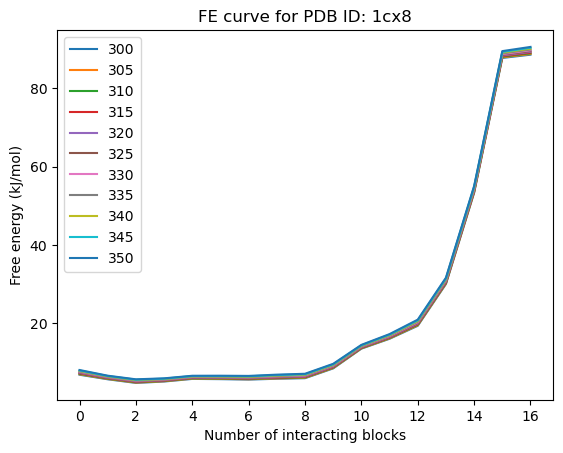

In [376]:
def plot_g_vecs(g_vecs, temps, id, save = False):
    for temp in temps:
        plt.plot(g_vecs[temp])
    plt.legend(temps)
    plt.title(f'FE curve for PDB ID: {id}')
    plt.xlabel('Number of interacting blocks')
    plt.ylabel('Free energy (kJ/mol)')
    if save:
        plt.savefig(f'../plots/FE_curve_{id}.jpg')
    plt.show()

plot_g_vecs(g_vecs, range(min_temp, max_temp + temp_step, temp_step), id, save = True)


In [377]:
import plotly.graph_objects as go 

z = g_vecs

fig = go.Figure(data=[go.Surface(x=g_vecs.columns, y=np.linspace(1, N_PLANES, N_PLANES), z=z.values)])
fig.update_layout(title='Free Energy Landscape',
                  scene=dict(xaxis_title='Temperature (K)', yaxis_title='Structured Elems', zaxis_title='Free Energy (kJ/mol)'),
                  width=750, height=750, autosize = False,
                  margin=dict(l=65, r=50, b=65, t=90)
                  )



In [378]:
#  save g_vecs to a csv file
import os

os.makedirs('../g_vals', exist_ok=True)
g_vecs.to_csv(f'../g_vals/g_vals_{id}.csv', index=False)

# master matrix to csv
os.makedirs('../master_matrix', exist_ok=True)
fin_master_matrix.to_csv(f'../master_matrix/master_matrix_{id}.csv', index=False)


In [379]:
# analysis of free energy values based on the structured elements
struct_group = fin_master_matrix.groupby('struct_elem')

# get the structured elements with minimum free energy values
min_g_vals = g_vecs.min(axis='index')
print(min_g_vals)

# for each temperature, get the no of structured elements with minimum free energy values
min_g_vals_struct_elems = []
for temp in g_vecs.columns:
    min_g = min_g_vals[temp]
    min_g_vals_struct_elems += (g_vecs[temp].index[g_vecs[temp] == min_g].tolist())

min_g_vals_struct_elems = set(min_g_vals_struct_elems)
print('minimum free energy values occur when the number of structured elements interacting are :', min_g_vals_struct_elems)

300    4.696846
305    4.792234
310    4.886914
315    4.980873
320    5.074097
325    5.166579
330    5.258311
335    5.349287
340    5.439504
345    5.528961
350    5.617656
dtype: float64
minimum free energy values occur when the number of structured elements interacting are : {2}


In [380]:
# consider +- 1 structured elements from the minimum free energy structured elements
min_g_vals_struct_elems = list(min_g_vals_struct_elems)
if len(min_g_vals_struct_elems) > 1:
    min_g_vals_struct_elems = [min_g_vals_struct_elems[0] - 1, min_g_vals_struct_elems[0], min_g_vals_struct_elems[0] + 1]
else:
    min_g_vals_struct_elems = [min_g_vals_struct_elems[0]]

In [381]:
# find groups in master_matrix that have same number of structured elements as the minimum free energy structured elements
min_g_vals_groups = []
for struct_elem in min_g_vals_struct_elems:
    min_g_vals_groups.append(struct_group.get_group(struct_elem))

In [382]:
min_g_vals_groups

[      struct_elem       sw_part  start1  end1  start2  end2  type
 3               2  3.240403e+01       0     0       2     4     2
 18              2  7.249720e+00       0     0       3     5     2
 32              2  8.882020e-06       0     0       4     6     2
 45              2  9.080931e-11       0     0       5     7     2
 57              2  5.550778e-08       0     0       6     8     2
 ...           ...           ...     ...   ...     ...   ...   ...
 3192            2  1.840934e+01      12    13      15    16     2
 3194            2  1.941305e+01      12    14       0     0     1
 3195            2  1.941305e+01      12    14      16    16     2
 3204            2  8.681443e+00      13    15       0     0     1
 3209            2  1.054522e+00      14    16       0     0     1
 
 [288 rows x 7 columns]]

In [383]:
def generate_distribution(min_g_vals_groups, z_planes):
    arr_dist = []
    for group in min_g_vals_groups:
        order_arr = np.zeros(len(z_planes)+1).astype(int)
        for row in group.iterrows():
            s1 = int(row[1].start1)
            e1 = int(row[1].end1)
            s2 = int(row[1].start2)
            e2 = int(row[1].end2)

            if row[1].type == 1:
                i = s1
                while i <= e1:
                    order_arr[i] += 1
                    i += 1
            
            if row[1].type == 2:
                i = s1
                while i <= e1:
                    order_arr[i] += 1
                    i += 1
                i = s2
                while i <= e2:
                    order_arr[i] += 1
                    i += 1
    
        arr_dist.append(order_arr)
    
    return arr_dist

Text(0.5, 1.0, 'Distribution of interacting blocks in groups with minimum free energy values')

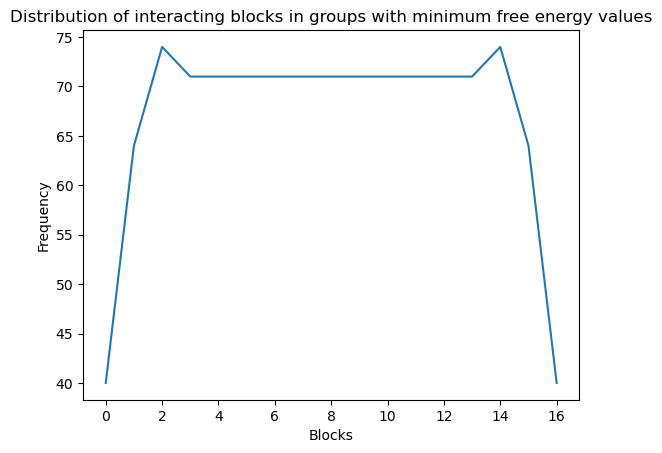

In [384]:
#  generate the distribution of interacting blocks
arr_dist = generate_distribution(min_g_vals_groups, z_planes)
plt.figure()
for arr in arr_dist:
    plt.plot(arr)
plt.xlabel('Blocks')
plt.ylabel('Frequency')
plt.title('Distribution of interacting blocks in groups with minimum free energy values')

In [385]:
'''
Finding the occurrence of each interacting block in the groups with minimum free energy values
This will give a good idea of the favourably interacting blocks. 
'''
for group in min_g_vals_groups:
    int_blocks = []
    for row in group.iterrows():
        row = row[1].astype(int)
        seq1 = list(range(row.start1, row.end1+1))
        seq2 = list(range(row.start2, row.end2+1))
        if len(seq1) != (row.struct_elem +1) and len(seq2) != (row.struct_elem + 1):
            int_blocks += [seq1, seq2]
        else:
            if len(seq1) == row.struct_elem + 1:
                int_blocks += [seq1]
            else:
                int_blocks += [seq2]
        # print(int_blocks)

freq = np.zeros(len(z_planes)+1).astype(int)

for block in int_blocks:
    for elem in block:
        freq[elem] += 1

In [386]:
freq_dict = {}
for i in range(len(freq)):
    freq_dict[i] = freq[i]

freq_dict = dict(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))

highest_freq_dict = list(freq_dict.items())[:10]

def max_freq_residues(highest_freq_dict):
    max_freq_residues_ch1 = []
    max_freq_residues_ch2 = []

    for elem, _ in highest_freq_dict:
        block1 = (interchain_intr.loc[interchain_intr.section == elem]).atom1_resnum
        block2 = (interchain_intr.loc[interchain_intr.section == elem]).atom2_resnum
        if block1.empty or block2.empty:
            continue
        max_freq_residues_ch1 += list(block1)
        max_freq_residues_ch2 += list(block2)

    return max_freq_residues_ch1, max_freq_residues_ch2

max_freq_residues_elec1, max_freq_residues_elec2 = max_freq_residues(highest_freq_dict)
max_freq_residues_vdw1, max_freq_residues_vdw2 = max_freq_residues(highest_freq_dict)

#  find frequency of each residue in the interacting blocks with highest frequencies

def count_residue_frequencies_elec(max_freq_residues_elec1, max_freq_residues_elec2):
    res_freq_elec1 = {}
    for res in max_freq_residues_elec1:
        if res in res_freq_elec1:
            res_freq_elec1[res] += 1
        else:
            res_freq_elec1[res] = 1

    res_freq_elec2 = {}
    for res in max_freq_residues_elec2:
        if res in res_freq_elec2:
            res_freq_elec2[res] += 1
        else:
            res_freq_elec2[res] = 1

    res_freq_elec_sorted1 = dict(sorted(res_freq_elec1.items(), key=lambda x: x[1], reverse=True))
    res_freq_elec_sorted2 = dict(sorted(res_freq_elec2.items(), key = lambda x: x[1], reverse = True))
    return res_freq_elec1,res_freq_elec2

res_freq_elec1, res_freq_elec2 = count_residue_frequencies_elec(max_freq_residues_elec1, max_freq_residues_elec2)

print("For Electrostatic interactions: ")
print(f'Residues frequently observed to be interacting in the lowest energy state in chain 1 {res_freq_elec1.keys()}')
print(f'Residues frequently observed to be interacting in the lowest energy state in chain 2 {res_freq_elec2.keys()}')
print('-----------------------------------')

def count_residue_frequencies_vdw(max_freq_residues_vdw1, max_freq_residues_vdw2):
    res_freq_vdw1 = {}
    for res in max_freq_residues_vdw1:
        if res in res_freq_vdw1:
            res_freq_vdw1[res] += 1
        else:
            res_freq_vdw1[res] = 1

    res_freq_vdw2 = {}
    for res in max_freq_residues_vdw2:
        if res in res_freq_vdw2:
            res_freq_vdw2[res] += 1
        else:
            res_freq_vdw2[res] = 1

    res_freq_vdw_sorted1 = dict(sorted(res_freq_vdw1.items(), key = lambda x: x[1], reverse = True))
    res_freq_vdw_sorted2 = dict(sorted(res_freq_vdw2.items(), key = lambda x: x[1], reverse = True))
    return res_freq_vdw1,res_freq_vdw2

res_freq_vdw1, res_freq_vdw2 = count_residue_frequencies_vdw(max_freq_residues_vdw1, max_freq_residues_vdw2)

print('For Van der Waals interactions: ')
print(f'Atoms frequently observed to be interacting in the lowest energy state in chain 1 {res_freq_vdw1.keys()}')
print(f'Atoms frequently observed to be interacting in the lowest energy state in chain 2 {res_freq_vdw2.keys()}')
print('-----------------------------------')

For Electrostatic interactions: 
Residues frequently observed to be interacting in the lowest energy state in chain 1 dict_keys([180, 184, 186, 394, 400, 477, 401, 668, 672, 676, 475, 667, 680, 684, 693, 698, 398, 446, 673, 677, 694, 664, 648, 655, 659, 707, 752, 755])
Residues frequently observed to be interacting in the lowest energy state in chain 2 dict_keys([655, 648, 757, 752, 755, 659, 677, 664, 680, 684, 667, 707, 673, 398, 446, 672, 676, 475, 698, 401, 694, 668, 477, 400, 693, 394])
-----------------------------------
For Van der Waals interactions: 
Atoms frequently observed to be interacting in the lowest energy state in chain 1 dict_keys([180, 184, 186, 394, 400, 477, 401, 668, 672, 676, 475, 667, 680, 684, 693, 698, 398, 446, 673, 677, 694, 664, 648, 655, 659, 707, 752, 755])
Atoms frequently observed to be interacting in the lowest energy state in chain 2 dict_keys([655, 648, 757, 752, 755, 659, 677, 664, 680, 684, 667, 707, 673, 398, 446, 672, 676, 475, 698, 401, 694, 66

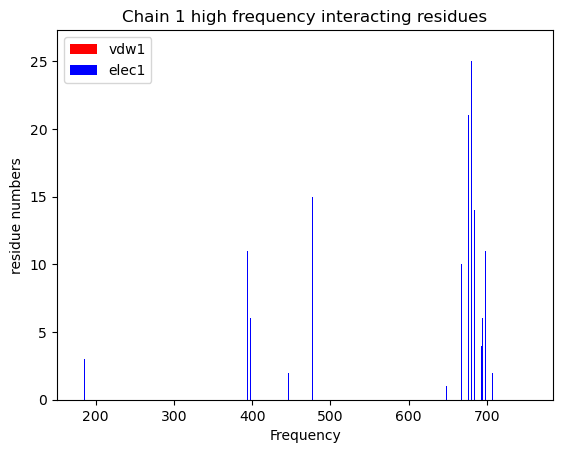

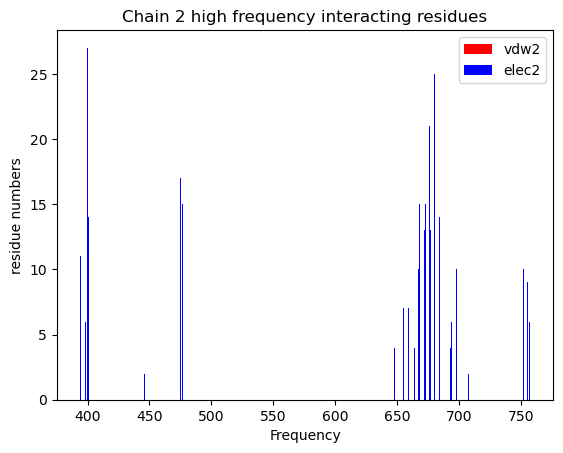

In [387]:
plt.bar(list(res_freq_vdw1.keys()), list(res_freq_vdw1.values()), color='r', label='vdw1')
plt.bar(list(res_freq_elec1.keys()), list(res_freq_elec1.values()), color='b', label='elec1')

plt.title('Chain 1 high frequency interacting residues')
plt.xlabel('Frequency')
plt.ylabel('residue numbers')
plt.legend()
plt.show()

plt.bar(list(res_freq_vdw2.keys()), list(res_freq_vdw2.values()), color='r', label='vdw2')
plt.bar(list(res_freq_elec2.keys()), list(res_freq_elec2.values()), color='b', label='elec2')

plt.title('Chain 2 high frequency interacting residues')
plt.xlabel('Frequency')
plt.ylabel('residue numbers')
plt.legend()
plt.show()


In [388]:
def get_block_g_vals(id, min_g_vals_struct_elems):
   master_matrix = pd.read_csv(f'../master_matrix/master_matrix_{id}.csv')
   min_FE_macrostate = min_g_vals_struct_elems[0]
   min_FE_group = master_matrix.groupby('struct_elem').get_group(min_FE_macrostate)

   blockwise_sw = {}
   total_sw = 0
   TEMP = 300
   R = 8.314/1000

   for i in range(len(min_FE_group)):
      row = min_FE_group.iloc[i]
      
      s1 = row.start1
      s2 = row.start2
      e1 = row.end1
      e2 = row.end2
      arr_type = row.type
      sw_part = row.sw_part
      total_sw += sw_part

      if arr_type == 1:
         i = s1
         while i <= e1:
            if i in blockwise_sw.keys():
               blockwise_sw[i] += sw_part
            else:
               blockwise_sw[i] = sw_part
            i+=1
      
      if arr_type == 2:
         i = s1
         while i <= e1:
            if i in blockwise_sw.keys():
               blockwise_sw[i] += sw_part
            else:
               blockwise_sw[i] = sw_part
            i+=1
         i = s2
         while i <= e2:
            if i in blockwise_sw.keys():
               blockwise_sw[i] += sw_part
            else:
               blockwise_sw[i] = sw_part
            i+=1

   blockwise_g_vals = {}
   for i in blockwise_sw.keys():
      blockwise_g_vals[i] = -R*TEMP*math.log(blockwise_sw[i] / total_sw)
   
   blockwise_g_vals = dict(sorted(blockwise_g_vals.items(), key = lambda x: x[0]))
   return blockwise_g_vals


In [389]:
import pandas as pd
import numpy as np
from collections import defaultdict

def get_block_g_vals2(id, min_g_vals_struct_elems):
    master_matrix = pd.read_csv(f'../master_matrix/master_matrix_{id}.csv')
    min_FE_macrostate = min_g_vals_struct_elems[0]
    min_FE_group = master_matrix[master_matrix['struct_elem'] == min_FE_macrostate]

    TEMP = 300
    R = 8.314/1000
    
    blockwise_sw = defaultdict(float)
    total_sw = 0

    for _, row in min_FE_group.iterrows():
        sw_part = row['sw_part']
        total_sw += sw_part

        ranges = [(row['start1'], row['end1'])]
        if row['type'] == 2:
            ranges.append((row['start2'], row['end2']))

        for start, end in ranges:
            for i in range(int(start), int(end) + 1):
                blockwise_sw[i] += sw_part

    log_total_sw = np.log(total_sw)
    blockwise_g_vals = {
        i: -R * TEMP * (np.log(sw) - log_total_sw)
        for i, sw in blockwise_sw.items()
    }

    return dict(sorted(blockwise_g_vals.items()))


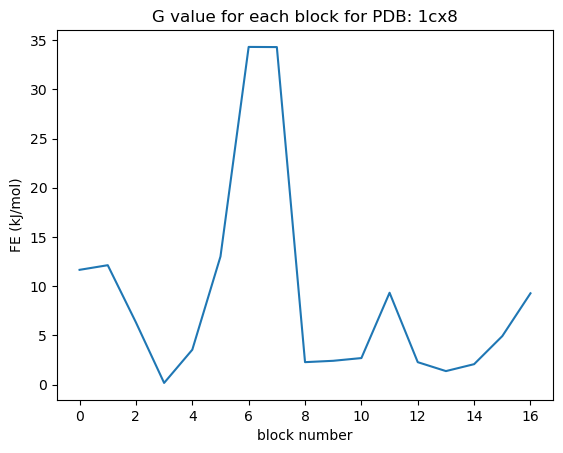

In [390]:
block_g_vals = get_block_g_vals2(id, list(min_g_vals_struct_elems))

plt.plot(block_g_vals.keys(), block_g_vals.values())    
plt.title(f"G value for each block for PDB: {id}")
plt.xlabel('block number')
plt.ylabel('FE (kJ/mol)')
plt.savefig(f'blockwise_FE/blockwise_{id}.jpg')
plt.show()

In [391]:
res_elec_list = list(res_freq_elec1.keys()) + list(res_freq_elec2.keys())
res_elec_list = list(set(res_elec_list))

res_vdw_list = list(res_freq_vdw1.keys()) + list(res_freq_vdw2.keys())
res_vdw_list = list(set(res_vdw_list))

res_list = list(set(res_elec_list + res_vdw_list))

def make_mod_pdb_file(id):
    file = f'{id}.pdb'
    with open(file, 'r') as f:
        lines = f.readlines()
    f.close()

    # make a new pdb file with _mod suffix
    if not os.path.exists('../mod_pdb_files'):
        os.makedirs('../mod_pdb_files', exist_ok=True)
    
    with open(f'../mod_pdb_files/{id}_mod.pdb', 'w') as f:
        for line in lines:
            f.write(line)
    f.close()

    return f'../mod_pdb_files/{id}_mod.pdb'

def modify_pdb(res_list, pdb_file_path):

    pandaspdb_obj = pandaspdb.PandasPdb()
    pandaspdb_obj.read_pdb(pdb_file_path)
    df = pandaspdb_obj.df['ATOM']
    pdb_id = pdb_file_path.split('/')[-1].split('.')[0]
    # generate a dict of the z-range for each section
    z_range = {}
    for i in range(len(z_planes)-1):
        z_range[i] = (z_planes[i], z_planes[i+1])

    for row in df.iterrows():
        if row[1].residue_number in res_list:
            z = row[1].z_coord
            for key in z_range.keys():
                if z_range[key][0] <= z <= z_range[key][1]:
                    if key in block_g_vals.keys():
                        df.at[row[0], 'b_factor'] = block_g_vals[key]
                    else:
                        df.at[row[0], 'b_factor'] = 99.99
                    break

    if not os.path.exists('../mod_pdb_files'):
        os.makedirs('../mod_pdb_files', exist_ok=True)

    mod_file_path = f'../mod_pdb_files/{pdb_id}_mod.pdb'

    pandaspdb_obj.df['ATOM'] = df
    pandaspdb_obj.to_pdb(mod_file_path, records=None)
    
    return mod_file_path

pdb_file_dir = '/Users/aaditmahajan/Documents/year 3/WSME project/workflow/pdb_files'
pdb_file_path = modify_pdb(res_list, os.path.join(pdb_file_dir, f'{id}.pdb'))

print(f'Modified pdb file {pdb_file_path}')


Modified pdb file ../mod_pdb_files/1cx8_mod.pdb
